In [ ]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS

## Read Data

In [ ]:
# Import data by upload
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
# Import data by API (upload kaggle.json file first)
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d ruchi798/stress-analysis-in-social-media

  0% 0.00/1.31M [00:00<?, ?B/s]
100% 1.31M/1.31M [00:00<00:00, 36.3MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile("/content/stress-analysis-in-social-media.zip","r") as zip_ref:
    zip_ref.extractall("/content")

In [ ]:
# Read data
train_df = pd.read_csv('dreaddit-train.csv')
test_df = pd.read_csv('dreaddit-test.csv')

In [ ]:
train_df.head(2)

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,lex_liwc_Authentic,lex_liwc_Tone,lex_liwc_WPS,lex_liwc_Sixltr,lex_liwc_Dic,lex_liwc_function,lex_liwc_pronoun,lex_liwc_ppron,lex_liwc_i,lex_liwc_we,lex_liwc_you,lex_liwc_shehe,lex_liwc_they,lex_liwc_ipron,lex_liwc_article,lex_liwc_prep,lex_liwc_auxverb,lex_liwc_adverb,lex_liwc_conj,lex_liwc_negate,lex_liwc_verb,lex_liwc_adj,lex_liwc_compare,lex_liwc_interrog,lex_liwc_number,lex_liwc_quant,lex_liwc_affect,...,lex_liwc_motion,lex_liwc_space,lex_liwc_time,lex_liwc_work,lex_liwc_leisure,lex_liwc_home,lex_liwc_money,lex_liwc_relig,lex_liwc_death,lex_liwc_informal,lex_liwc_swear,lex_liwc_netspeak,lex_liwc_assent,lex_liwc_nonflu,lex_liwc_filler,lex_liwc_AllPunc,lex_liwc_Period,lex_liwc_Comma,lex_liwc_Colon,lex_liwc_SemiC,lex_liwc_QMark,lex_liwc_Exclam,lex_liwc_Dash,lex_liwc_Quote,lex_liwc_Apostro,lex_liwc_Parenth,lex_liwc_OtherP,lex_dal_max_pleasantness,lex_dal_max_activation,lex_dal_max_imagery,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,116,72.64,15.04,89.26,1.00,29.00,12.93,87.07,56.03,16.38,12.07,9.48,0.00,0.86,1.72,0.0,4.31,3.45,19.83,7.76,5.17,4.31,1.72,16.38,6.03,3.45,0.86,1.72,1.72,8.62,...,0.86,10.34,6.03,0.86,0.0,0.0,0.00,2.59,0.0,0.86,0.86,0.00,0.0,0.0,0.0,21.55,9.48,3.45,0.86,0.86,0.0,0.0,0.0,5.17,1.72,0.00,0.00,2.8571,2.6250,3.0,1.000,1.125,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,109,79.08,76.85,56.75,98.18,27.25,21.10,87.16,48.62,11.93,7.34,1.83,2.75,2.75,0.00,0.0,4.59,8.26,13.76,6.42,3.67,8.26,0.92,15.60,2.75,0.92,0.92,2.75,0.92,5.50,...,2.75,10.09,1.83,11.01,0.0,0.0,0.92,0.00,0.0,1.83,0.00,0.92,0.0,0.0,0.0,14.68,4.59,2.75,0.00,0.00,0.0,0.0,0.0,0.00,2.75,0.92,3.67,3.0000,2.8889,3.0,1.125,1.000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857


In [ ]:
test_df.head(2)

,id,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,lex_liwc_Authentic,lex_liwc_Tone,lex_liwc_WPS,lex_liwc_Sixltr,lex_liwc_Dic,lex_liwc_function,lex_liwc_pronoun,lex_liwc_ppron,lex_liwc_i,lex_liwc_we,lex_liwc_you,lex_liwc_shehe,lex_liwc_they,lex_liwc_ipron,lex_liwc_article,lex_liwc_prep,lex_liwc_auxverb,lex_liwc_adverb,lex_liwc_conj,lex_liwc_negate,lex_liwc_verb,lex_liwc_adj,lex_liwc_compare,lex_liwc_interrog,lex_liwc_number,lex_liwc_quant,lex_liwc_affect,...,lex_liwc_motion,lex_liwc_space,lex_liwc_time,lex_liwc_work,lex_liwc_leisure,lex_liwc_home,lex_liwc_money,lex_liwc_relig,lex_liwc_death,lex_liwc_informal,lex_liwc_swear,lex_liwc_netspeak,lex_liwc_assent,lex_liwc_nonflu,lex_liwc_filler,lex_liwc_AllPunc,lex_liwc_Period,lex_liwc_Comma,lex_liwc_Colon,lex_liwc_SemiC,lex_liwc_QMark,lex_liwc_Exclam,lex_liwc_Dash,lex_liwc_Quote,lex_liwc_Apostro,lex_liwc_Parenth,lex_liwc_OtherP,lex_dal_max_pleasantness,lex_dal_max_activation,lex_dal_max_imagery,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,896,relationships,7nu7as,"[50, 55]","Its like that, if you want or not.“ ME: I have...",0,0.8,1.514981e+09,22,-1.238793,55,2.82,57.22,55.41,5.95,11.0,7.27,94.55,67.27,29.09,18.18,5.45,0.00,9.09,3.64,0.0,10.91,0.00,12.73,7.27,1.82,14.55,7.27,18.18,1.82,3.64,1.82,5.45,0.00,1.82,...,0.00,1.82,10.91,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.64,12.73,5.45,1.82,0.0,0.0,0.0,0.0,1.82,1.82,0.0,0.00,2.7143,2.8889,2.6,1.0,1.200,1.0,1.65864,1.32245,1.80264,0.63,62,-0.148707,0.000000
1,19059,anxiety,680i6d,"(5, 10)",I man the front desk and my title is HR Custom...,0,1.0,1.493348e+09,5,7.684583,72,64.56,50.00,31.19,92.40,14.4,25.00,84.72,44.44,9.72,8.33,6.94,1.39,0.00,0.00,0.0,1.39,5.56,11.11,8.33,5.56,8.33,0.00,13.89,1.39,0.00,2.78,2.78,1.39,4.17,...,1.39,4.17,1.39,22.22,0.0,0.0,4.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.28,6.94,4.17,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,4.17,2.4444,2.8889,3.0,1.4,1.125,1.0,1.69133,1.69180,1.97249,1.00,2,7.398222,-0.065909


In [ ]:
data = pd.concat([train_df, test_df], axis=0, ignore_index=True)
data.shape

(3553, 116)

## Identifikasi Masalah

Permasalahan yang akan diselesaikan adalah melakukan klasifikasi pada text komentar untuk menentukan apakah komentar tersebut ditulis oleh pengguna yang sedang stress/tidak stress. Terdapat banyak variabel yang menjadi penentu untuk melakukan klasifikasi tersebut. Lebih lanjut, disini saya akan menggunakan pendekatan predictive analytics yang bertujuan untuk melakukan prediksi. Untuk metodenya, saya akan menggunakan algoritma SVM dengan C-Support Vector Classification atau SVC, dan terakhir Naive Bayes.

## Data Description

Subreddit: Subtopik di Reddit

post_id: ID dari post/komentar

sentence_range: Panjang dari kalimat

text: Text yang ditulis pengguna

id: ID pengguna 

label: Label/ target

## Data Understanding

In [ ]:
x, y = data.shape
print("Jumlah data: ", x)
print("Jumlah Fitur: ", y)

Jumlah data:  3553
Jumlah Fitur:  113


In [ ]:
data.head(3)

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,lex_liwc_Authentic,lex_liwc_Tone,lex_liwc_WPS,lex_liwc_Sixltr,lex_liwc_Dic,lex_liwc_function,lex_liwc_pronoun,lex_liwc_ppron,lex_liwc_i,lex_liwc_we,lex_liwc_you,lex_liwc_shehe,lex_liwc_they,lex_liwc_ipron,lex_liwc_article,lex_liwc_prep,lex_liwc_auxverb,lex_liwc_adverb,lex_liwc_conj,lex_liwc_negate,lex_liwc_verb,lex_liwc_adj,lex_liwc_compare,lex_liwc_interrog,lex_liwc_number,lex_liwc_quant,lex_liwc_affect,...,lex_liwc_motion,lex_liwc_space,lex_liwc_time,lex_liwc_work,lex_liwc_leisure,lex_liwc_home,lex_liwc_money,lex_liwc_relig,lex_liwc_death,lex_liwc_informal,lex_liwc_swear,lex_liwc_netspeak,lex_liwc_assent,lex_liwc_nonflu,lex_liwc_filler,lex_liwc_AllPunc,lex_liwc_Period,lex_liwc_Comma,lex_liwc_Colon,lex_liwc_SemiC,lex_liwc_QMark,lex_liwc_Exclam,lex_liwc_Dash,lex_liwc_Quote,lex_liwc_Apostro,lex_liwc_Parenth,lex_liwc_OtherP,lex_dal_max_pleasantness,lex_dal_max_activation,lex_dal_max_imagery,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1.521614e+09,5,1.806818,116,72.64,15.04,89.26,1.00,29.00,12.93,87.07,56.03,16.38,12.07,9.48,0.00,0.86,1.72,0.0,4.31,3.45,19.83,7.76,5.17,4.31,1.72,16.38,6.03,3.45,0.86,1.72,1.72,8.62,...,0.86,10.34,6.03,0.86,0.0,0.0,0.00,2.59,0.0,0.86,0.86,0.00,0.0,0.0,0.0,21.55,9.48,3.45,0.86,0.86,0.0,0.0,0.0,5.17,1.72,0.00,0.00,2.8571,2.6250,3.0,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1.527010e+09,4,9.429737,109,79.08,76.85,56.75,98.18,27.25,21.10,87.16,48.62,11.93,7.34,1.83,2.75,2.75,0.00,0.0,4.59,8.26,13.76,6.42,3.67,8.26,0.92,15.60,2.75,0.92,0.92,2.75,0.92,5.50,...,2.75,10.09,1.83,11.01,0.0,0.0,0.92,0.00,0.0,1.83,0.00,0.92,0.0,0.0,0.0,14.68,4.59,2.75,0.00,0.00,0.0,0.0,0.0,0.00,2.75,0.92,3.67,3.0000,2.8889,3.0,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1.535936e+09,2,7.769821,167,33.80,76.38,86.24,25.77,33.40,17.37,91.02,61.68,25.15,16.17,8.98,1.80,1.80,2.99,0.6,8.98,5.39,12.57,10.18,1.80,5.99,1.20,20.96,1.20,0.60,0.60,1.20,1.80,2.40,...,4.79,5.99,5.39,0.00,1.2,0.6,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,10.78,2.40,3.59,0.00,0.00,0.6,0.0,0.0,2.40,1.80,0.00,0.00,2.7143,3.0000,3.0,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894


In [ ]:
data.describe()

,id,label,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,lex_liwc_Authentic,lex_liwc_Tone,lex_liwc_WPS,lex_liwc_Sixltr,lex_liwc_Dic,lex_liwc_function,lex_liwc_pronoun,lex_liwc_ppron,lex_liwc_i,lex_liwc_we,lex_liwc_you,lex_liwc_shehe,lex_liwc_they,lex_liwc_ipron,lex_liwc_article,lex_liwc_prep,lex_liwc_auxverb,lex_liwc_adverb,lex_liwc_conj,lex_liwc_negate,lex_liwc_verb,lex_liwc_adj,lex_liwc_compare,lex_liwc_interrog,lex_liwc_number,lex_liwc_quant,lex_liwc_affect,lex_liwc_posemo,lex_liwc_negemo,lex_liwc_anx,lex_liwc_anger,...,lex_liwc_motion,lex_liwc_space,lex_liwc_time,lex_liwc_work,lex_liwc_leisure,lex_liwc_home,lex_liwc_money,lex_liwc_relig,lex_liwc_death,lex_liwc_informal,lex_liwc_swear,lex_liwc_netspeak,lex_liwc_assent,lex_liwc_nonflu,lex_liwc_filler,lex_liwc_AllPunc,lex_liwc_Period,lex_liwc_Comma,lex_liwc_Colon,lex_liwc_SemiC,lex_liwc_QMark,lex_liwc_Exclam,lex_liwc_Dash,lex_liwc_Quote,lex_liwc_Apostro,lex_liwc_Parenth,lex_liwc_OtherP,lex_dal_max_pleasantness,lex_dal_max_activation,lex_dal_max_imagery,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
count,3553.000000,3553.000000,3553.000000,3.553000e+03,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,...,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000,3553.000000
mean,13774.009288,0.522657,0.790644,1.517999e+09,19.543203,4.688569,85.929918,35.140816,40.437610,67.622440,33.216364,18.123392,14.863673,92.382378,58.657658,19.825457,14.012184,9.125449,0.767889,0.847557,2.690324,0.580825,5.801368,4.915759,13.385120,10.291798,6.070735,7.626552,2.265837,19.398945,4.396302,2.297250,1.590664,1.430433,2.261396,6.088033,2.679491,3.316009,0.927610,0.918829,...,1.998593,6.301894,6.242764,1.853484,0.781759,0.622620,0.773031,0.119234,0.142111,0.824672,0.247450,0.248033,0.120977,0.122246,0.050870,16.989164,6.092857,3.572328,0.212097,0.118551,0.507219,0.186544,0.483178,0.463831,3.206364,0.770574,1.375390,2.797408,2.706582,2.947537,1.086601,1.119619,1.000225,1.722884,1.535102,1.879306,0.846088,9.747819,5.458644,0.041667
std,17424.172858,0.499557,0.218379,1.552489e+07,87.263634,3.301673,32.105144,26.452202,31.449231,32.658996,35.165154,9.066482,5.456838,5.143117,6.729017,5.572028,4.781504,4.612681,1.569870,2.074341,3.616338,1.282187,3.225855,2.617123,3.648858,3.644291,3.182931,2.834074,1.891539,4.716351,2.691857,1.974408,1.536017,1.912833,1.808069,3.473419,2.506741,2.980028,1.481809,1.424927,...,1.810227,3.278859,3.785470,2.439636,1.364916,1.200338,1.719157,0.547211,0.543504,1.318356,0.733665,0.726126,0.474723,0.409134,0.321367,11.756303,3.205000,2.848279,0.772208,0.496683,2.160414,0.978700,1.866224,1.286249,2.747326,1.691579,9.410229,0.161720,0.174038,0.126968,0.115371,0.086195,0.006708,0.048044,0.102542,0.058354,0.174756,20.324300,2.526593,0.195195
min,2.000000,0.000000,0.000000,1.483274e+09,0.000000,-6.620000,5.000000,1.000000,1.000000,1.000000,1.000000,2.400000,0.000000,27.910000,4.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [ ]:
data.describe(include=object)

,subreddit,post_id,sentence_range,text
count,3553,3553,3553,3553
unique,10,2929,194,3532
top,ptsd,8c6fwz,"[0, 5]",#NAME?
freq,711,6,431,4


### Data Visualization

In [ ]:
data_visual1 = data.groupby('subreddit')['id'].count().reset_index()
data_visual2 = data.groupby('label')['id'].count().reset_index()

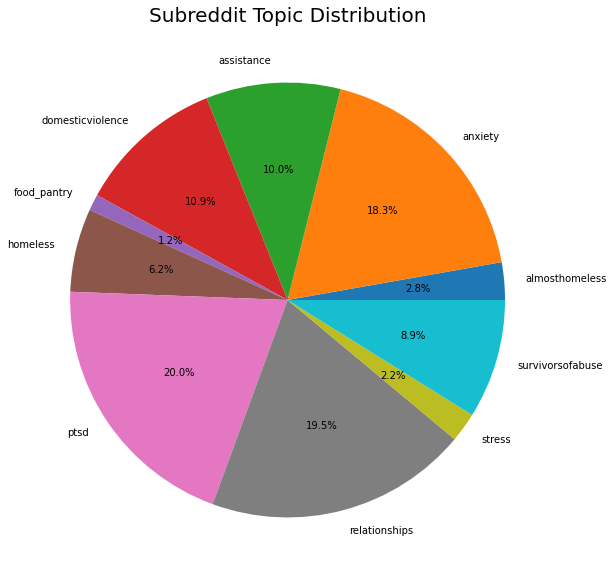

In [ ]:
plt.figure(figsize=(10, 10))
plt.pie(data_visual1['id'], labels = data_visual1['subreddit'], autopct='%1.1f%%')
plt.title('Subreddit Topic Distribution', fontsize=20)
plt.show()

Dengan pie chart, kami mengetahui distribusi sub-topik reddit pada data. Ditemukan data terbanyak ditulis pada sub-topik `relationships` dengan jumlah 19.5%, sedangkan data tersedikit ditulis pada sub-topik `food_pantry` dengan jumlah 1.2%

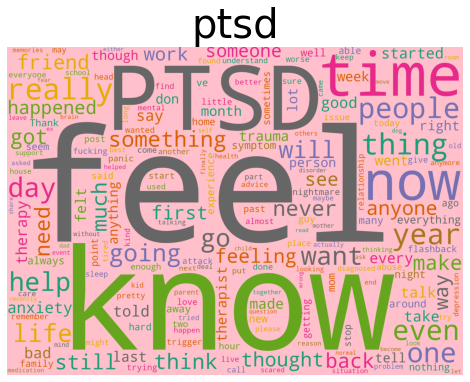

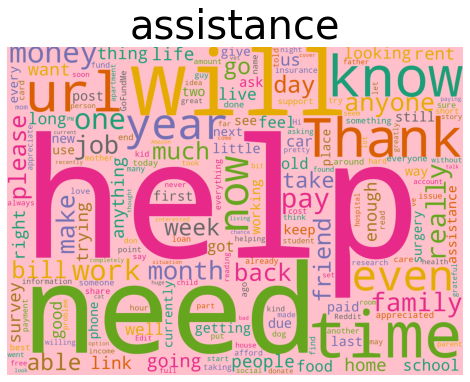

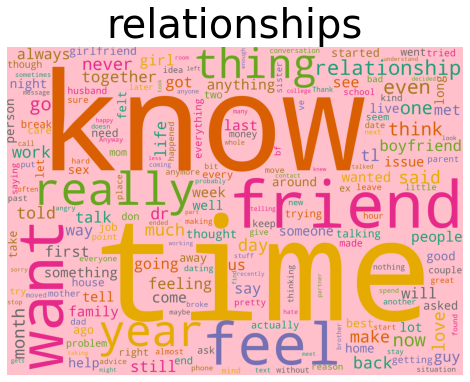

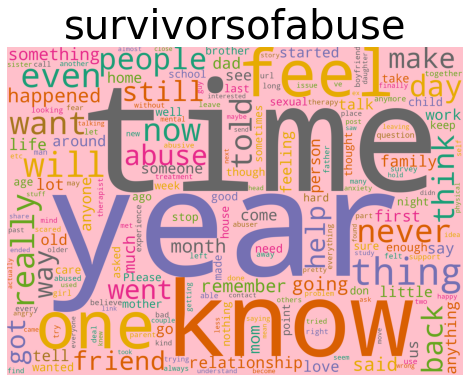

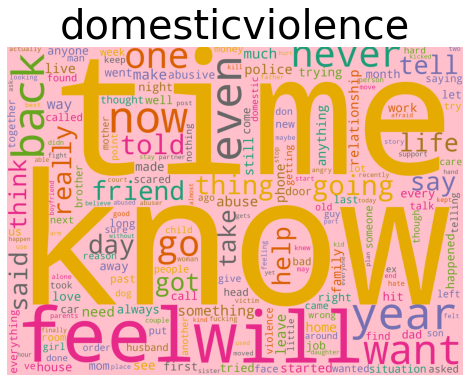

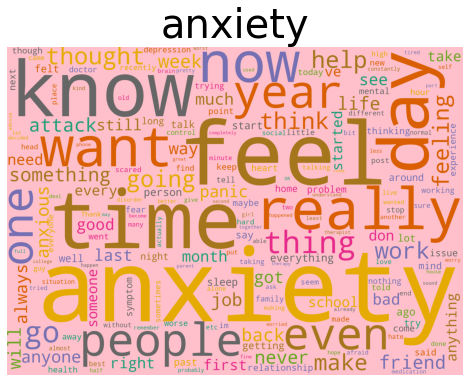

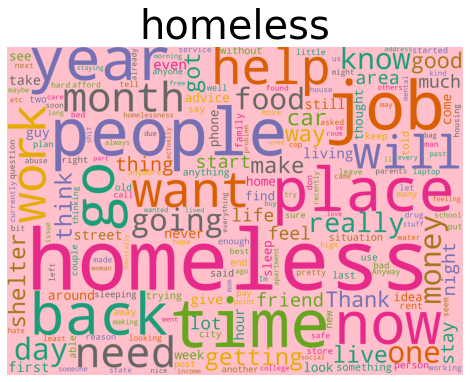

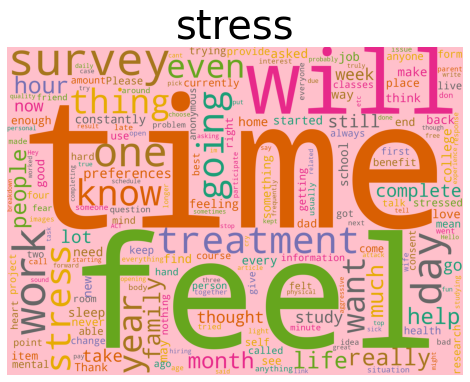

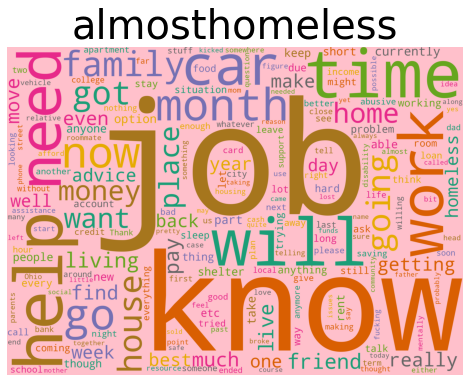

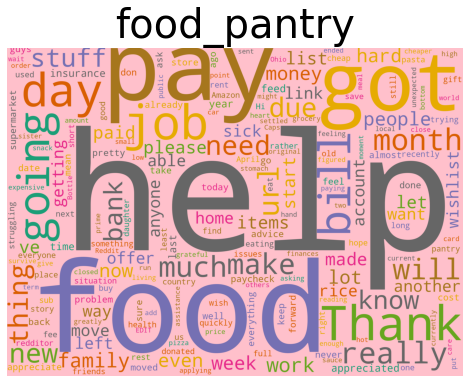

In [ ]:
for x in data['subreddit'].unique():
  plt.figure(figsize=(60,35))
  subset = data[data['subreddit']==x]
  text = subset.text.values
  cloud=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800).generate(" ".join(text))

  plt.subplot(5,2,1)
  plt.axis('off')
  plt.title(x,fontsize=40)
  plt.imshow(cloud)

Berikutnya dengan wordcloud, kami dapat mengetahui kata apa yang paling sering digunakan pada setiap sub-topik reddit. Sebagai contohnya, kata yang paling sering digunakan untuk sub-topik `ptsd` adalah *feel*, *know*, dan *ptsd*. Sedangkan kata yang paling sering digunakan untuk sub-topik `assistance` adalah *help*, *need*, dan *will*.

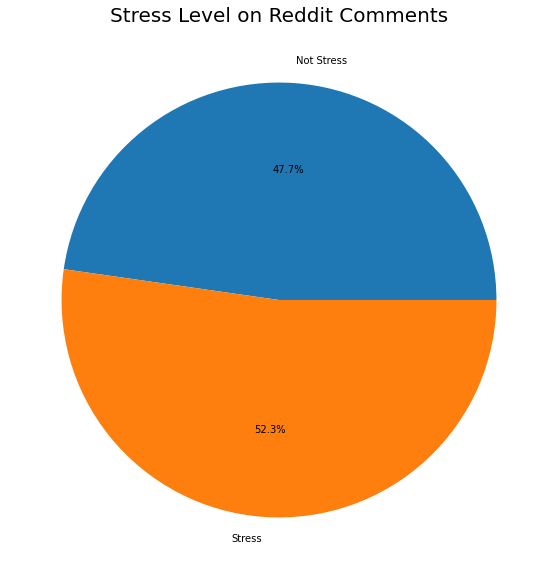

In [ ]:
plt.figure(figsize=(10, 10))
plt.pie(data_visual2['id'], labels = data_visual2['label'].replace([0, 1], ['Not Stress', 'Stress']), autopct='%1.1f%%')
plt.title('Stress Level on Reddit Comments', fontsize=20)
plt.show()

Terakhir dengan pie chart lagi, kami mengetahui bahwa distribusi label sangat baik dengan jumlah 47.7% untuk label `Not Stress` atau 0 dan 52.3% untuk label `Stress` atau 1.

## Data Preparation

Saya melakukan drop fitur yang sekiranya tidak mempunyai korelasi terhadap target/label yang akan diprediksi

In [ ]:
data = data.drop(['id', 'post_id', 'sentence_range'], axis=1)

In [ ]:
data.head(2)

,subreddit,text,label,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,lex_liwc_Authentic,lex_liwc_Tone,lex_liwc_WPS,lex_liwc_Sixltr,lex_liwc_Dic,lex_liwc_function,lex_liwc_pronoun,lex_liwc_ppron,lex_liwc_i,lex_liwc_we,lex_liwc_you,lex_liwc_shehe,lex_liwc_they,lex_liwc_ipron,lex_liwc_article,lex_liwc_prep,lex_liwc_auxverb,lex_liwc_adverb,lex_liwc_conj,lex_liwc_negate,lex_liwc_verb,lex_liwc_adj,lex_liwc_compare,lex_liwc_interrog,lex_liwc_number,lex_liwc_quant,lex_liwc_affect,lex_liwc_posemo,lex_liwc_negemo,lex_liwc_anx,...,lex_liwc_motion,lex_liwc_space,lex_liwc_time,lex_liwc_work,lex_liwc_leisure,lex_liwc_home,lex_liwc_money,lex_liwc_relig,lex_liwc_death,lex_liwc_informal,lex_liwc_swear,lex_liwc_netspeak,lex_liwc_assent,lex_liwc_nonflu,lex_liwc_filler,lex_liwc_AllPunc,lex_liwc_Period,lex_liwc_Comma,lex_liwc_Colon,lex_liwc_SemiC,lex_liwc_QMark,lex_liwc_Exclam,lex_liwc_Dash,lex_liwc_Quote,lex_liwc_Apostro,lex_liwc_Parenth,lex_liwc_OtherP,lex_dal_max_pleasantness,lex_dal_max_activation,lex_dal_max_imagery,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,"He said he had not felt that way before, sugge...",1,0.8,1.521614e+09,5,1.806818,116,72.64,15.04,89.26,1.00,29.00,12.93,87.07,56.03,16.38,12.07,9.48,0.00,0.86,1.72,0.0,4.31,3.45,19.83,7.76,5.17,4.31,1.72,16.38,6.03,3.45,0.86,1.72,1.72,8.62,1.72,6.9,0.86,...,0.86,10.34,6.03,0.86,0.0,0.0,0.00,2.59,0.0,0.86,0.86,0.00,0.0,0.0,0.0,21.55,9.48,3.45,0.86,0.86,0.0,0.0,0.0,5.17,1.72,0.00,0.00,2.8571,2.6250,3.0,1.000,1.125,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,"Hey there r/assistance, Not sure if this is th...",0,1.0,1.527010e+09,4,9.429737,109,79.08,76.85,56.75,98.18,27.25,21.10,87.16,48.62,11.93,7.34,1.83,2.75,2.75,0.00,0.0,4.59,8.26,13.76,6.42,3.67,8.26,0.92,15.60,2.75,0.92,0.92,2.75,0.92,5.50,5.50,0.0,0.00,...,2.75,10.09,1.83,11.01,0.0,0.0,0.92,0.00,0.0,1.83,0.00,0.92,0.0,0.0,0.0,14.68,4.59,2.75,0.00,0.00,0.0,0.0,0.0,0.00,2.75,0.92,3.67,3.0000,2.8889,3.0,1.125,1.000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857


### Checking Missing Values

Saya melakukan pengecekan data yang hilang (*missing values*) dan hasilnya 0

In [ ]:
print('Jumlah missing value :', data.isnull().sum().sum())

Jumlah missing value : 0


### Checking Duplicates

Saya melakukan pengecekan data yang duplikasi (*duplicates*) dan hasilnya 0

In [ ]:
print("Jumlah duplikasi :", data.duplicated().sum())

Jumlah duplikasi : 0


### Remove Some Feature 

Kemudian karena fiturnya terlalu banyak, disini saya melakukan pemilihan fitur (filter) dengan mencari fitur yang memiliki nilai korelasi diatas ambang batas dengan fitur label. Untuk nilai ambang batasnya, saya menggunakan nilai 0.30. Jadi, fitur dengan nilai korelasi >= 0.30 akan saya gunakan. Hal ini saya lakukan dengan pertimbangan bahwa menghilangkan fitur yang memiliki nilai korelasi kecil akan memperbaiki dan meningkatkan nilai akurasi pada tahap **Modeling**.

In [ ]:
data.corr()['label'].sort_values(ascending = True)[1:10]

lex_liwc_Clout             -0.392516
sentiment                  -0.307780
lex_dal_min_pleasantness   -0.290220
lex_liwc_posemo            -0.288324
lex_liwc_social            -0.245331
lex_liwc_Analytic          -0.233978
lex_liwc_you               -0.211981
lex_liwc_affiliation       -0.184311
lex_dal_avg_pleasantness   -0.170962
Name: label, dtype: float64

In [ ]:
data.corr()['label'].sort_values(ascending = False)[1:10]

lex_liwc_negemo       0.394988
lex_liwc_i            0.387434
lex_liwc_anx          0.271179
lex_liwc_Authentic    0.266833
lex_liwc_function     0.227150
lex_liwc_Dic          0.227076
lex_liwc_anger        0.217469
lex_liwc_feel         0.203389
lex_liwc_sad          0.202216
Name: label, dtype: float64

In [ ]:
new_data = data[['subreddit', 'confidence', 'sentiment', 'lex_liwc_negemo', 
                 'lex_liwc_i', 'lex_liwc_Clout', 'label']]

### Transform text to numeric

Berikutnya, saya mengubah fitur `subreddit` yang bersifat data kategorik ordinal menjadi data numerik dengan bantuan library LabelEncoder

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
new_data['subreddit'] = le.fit_transform(new_data['subreddit'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Kemudian untuk fitur `text` yang merupakan komentar, saya melakukan ekstraksi fitur dengan bantuan library TfidfVectorizer. TfidfVectorizer tersebut juga akan melakukan proses Tokenizing dan mengatasi Stopwords.

In [ ]:
text_data = data['text']

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    min_df=2, 
    ngram_range=(1, 2),
    lowercase=True, 
    max_features=4500, 
    stop_words='english',
    use_idf=True,
    smooth_idf=True)
tfidf = vectorizer.fit_transform(text_data).toarray()
tfidf = pd.DataFrame(tfidf)

In [ ]:
data_prepared = pd.concat([new_data, tfidf], axis=1)

Berikut hasil akhir dari proses Data Preparation yang telah saya lakukan.

In [ ]:
data_prepared.head()

,subreddit,confidence,sentiment,lex_liwc_negemo,lex_liwc_i,lex_liwc_Clout,label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,...,4460,4461,4462,4463,4464,4465,4466,4467,4468,4469,4470,4471,4472,4473,4474,4475,4476,4477,4478,4479,4480,4481,4482,4483,4484,4485,4486,4487,4488,4489,4490,4491,4492,4493,4494,4495,4496,4497,4498,4499
0,6,0.8,-0.002742,6.90,9.48,15.04,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1.0,0.292857,0.00,1.83,76.85,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,0.8,0.011894,1.20,8.98,76.38,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.080775,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.127197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7,0.6,0.141671,2.93,16.12,15.25,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9,0.8,-0.204167,7.87,7.87,28.71,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.087091,0.0,0.0,0.0,0.0,0.0,0.077275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modeling

In [ ]:
x = data_prepared.drop(['label'], axis=1)
y = data_prepared['label']

In [ ]:
from sklearn.model_selection import train_test_split, KFold
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
cv = KFold(n_splits=10, shuffle=True)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

### SVC Modeling

Modeling dengan gridSearchCV Kfold

In [ ]:
pipe_svc = Pipeline(steps=[("scaler", MinMaxScaler()), ("svc", SVC())])

parameter_svc = {
    'svc__C':(0.1, 1, 10),
    'svc__gamma':(1, 0.01, 0.001),
    }
svc = GridSearchCV(pipe_svc, parameter_svc, n_jobs=-1, cv=cv)
svc.fit(x, y)
svc_predictions = svc.predict(x)
print('Best parameter:', svc.best_params_)

# Score
print('Score:', svc.score(x, y))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Best parameter: {'svc__C': 10, 'svc__gamma': 0.01}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Score: 0.9603152265690965


### Naive Bayes Modeling

Modeling dengan gridSearchCV dan kfold

In [ ]:
pipe_nb = Pipeline(steps=[("scaler", MinMaxScaler()), ("nb", MultinomialNB())])

parameter_nb = {
    'nb__alpha':(0.1, 0, 1, 2, 5, 10),
    'nb__fit_prior':(True, False)
    }
mnb = GridSearchCV(pipe_nb, parameter_nb, n_jobs=-1, cv=cv)
mnb.fit(x, y)
mnb_predictions = mnb.predict(x)
print('Best parameter:', mnb.best_params_)

# Score
print('Score:', mnb.score(x, y))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Best parameter: {'nb__alpha': 5, 'nb__fit_prior': False}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Score: 0.8626512806079369


## Evaluasi Hasil

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix

In [ ]:
def evaluate(prediction):
  print(classification_report(y, prediction))

def cm_plot(matrix, name):
  fig, ax = plt.subplots(figsize=(7.5, 7.5))
  ax.matshow(matrix, cmap=plt.cm.Blues, alpha=0.3)
  for i in range(matrix.shape[0]):
      for j in range(matrix.shape[1]):
          ax.text(x=j, y=i,s=matrix[i, j], va='center', ha='center', size='xx-large')
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix {}'.format(name), fontsize=18)
  plt.show()

### SVC Evaluation 

In [ ]:
evaluate(svc_predictions)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1696
           1       0.96      0.96      0.96      1857

    accuracy                           0.96      3553
   macro avg       0.96      0.96      0.96      3553
weighted avg       0.96      0.96      0.96      3553



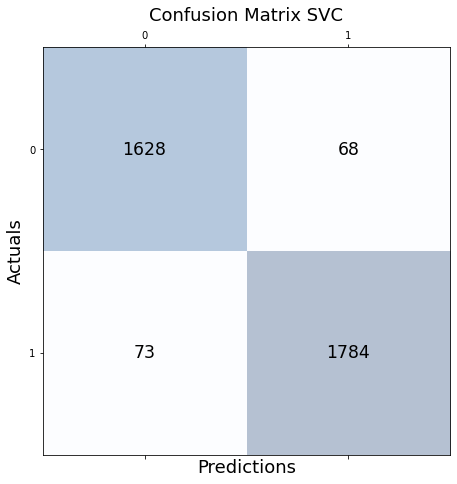

In [ ]:
cm_svc = cm(y, svc_predictions)
cm_plot(cm_svc, 'SVC')

### Naive Bayes Evaluation

In [ ]:
evaluate(mnb_predictions)

              precision    recall  f1-score   support

           0       0.90      0.80      0.85      1696
           1       0.84      0.92      0.87      1857

    accuracy                           0.86      3553
   macro avg       0.87      0.86      0.86      3553
weighted avg       0.87      0.86      0.86      3553



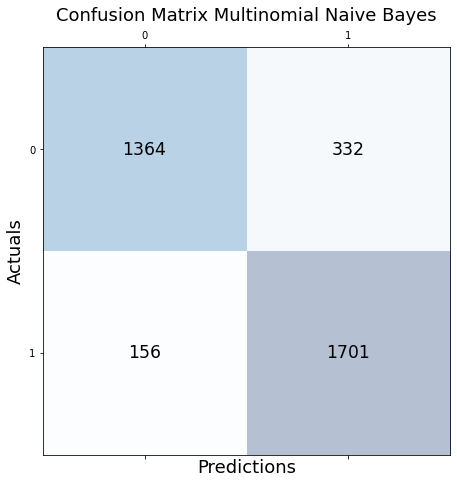

In [ ]:
cm_mnb = cm(y, mnb_predictions)
cm_plot(cm_mnb, 'Multinomial Naive Bayes')

## Deploy Model

In [ ]:
import pickle
import bz2

In [ ]:
# filename = 'trained_model.sav'
# pickle.dump(svc, open(filename, 'wb'))